In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima_model import ARIMA
from itertools import product
from tqdm import tqdm_notebook

warnings.filterwarnings('ignore')

In [12]:
emissions = pd.read_csv("D:\Kuliah\BasicStats\EVEN_FinalProj\datasets\API_EN.ATM.CO2E.PC_DS2_en_csv_v2_3159114.csv", skiprows=3)

# processing the CO2 emissions dataset to only show Indonesia
indo_emissions = emissions.loc[emissions["Country Name"] == "Indonesia"]
indo_emissions.drop("Unnamed: 65", axis=1, inplace=True)
# dropping the NaN values as it doesn't affect the analysis
indo_emissions.drop(["2019", "2020"], axis=1, inplace=True)

# slicing the dataframe to get usable features
indo_emissions = indo_emissions.iloc[:, 4:]
indo_emissions = indo_emissions.transpose()
indo_emissions.rename(columns={106:"CO2 emissions (metric tons per capita)"}, inplace=True)
indo_emissions.index = pd.to_datetime(indo_emissions.index)

indo_emissions

,CO2 emissions (metric tons per capita)
1960-01-01,0.243920
1961-01-01,0.288848
1962-01-01,0.248553
1963-01-01,0.239783
1964-01-01,0.229458
1965-01-01,0.246241
1966-01-01,0.227084
1967-01-01,0.232007
1968-01-01,0.253602
1969-01-01,0.298784


<AxesSubplot:>

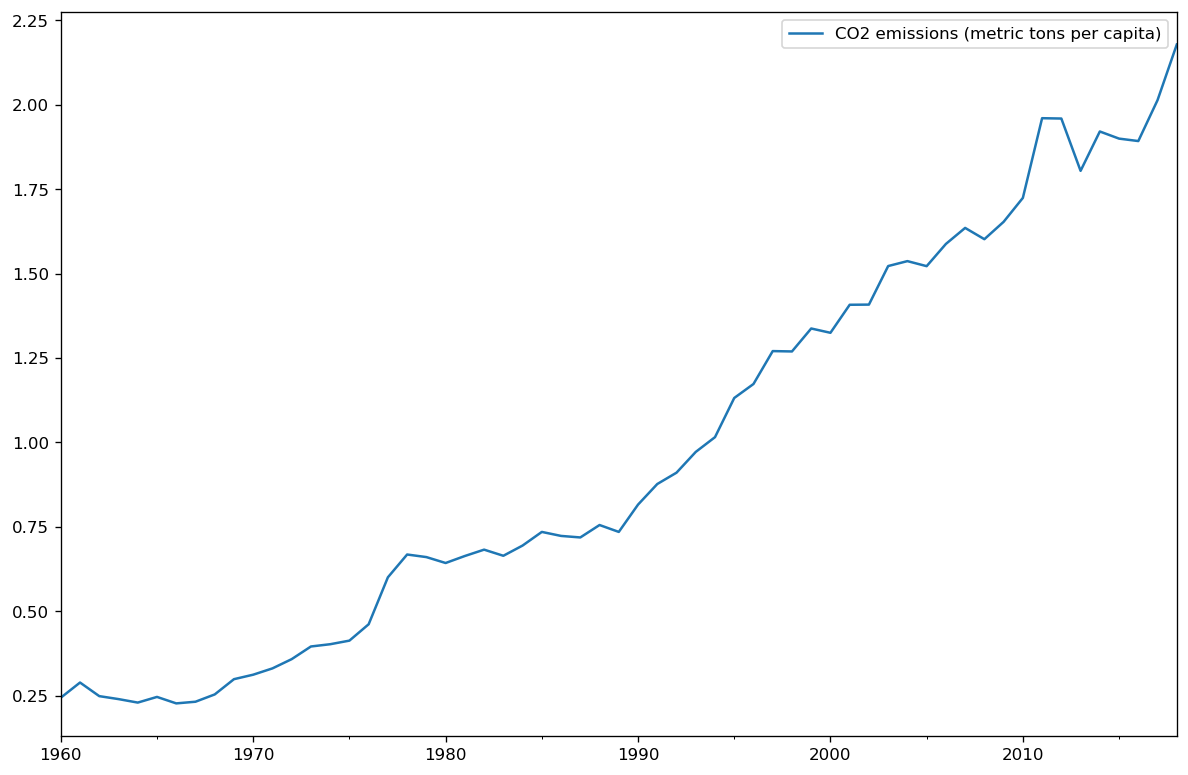

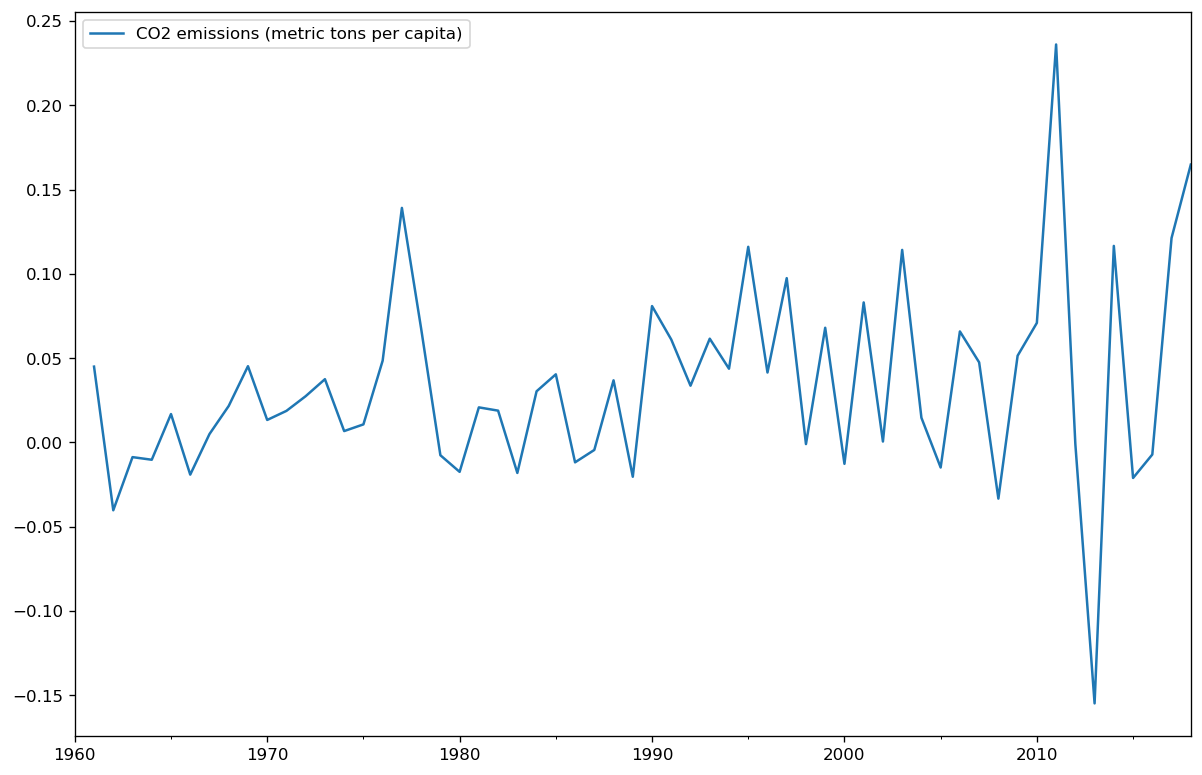

In [31]:
# plotting the original dataset and the first differential
indo_emissions.plot(figsize=(12, 8))
indo_emissions.diff().plot(figsize=(12, 8))

In [32]:
# forecasting using the ARIMA model
# using the ADF test to find the p-value
# since the p-value is above the threshhold (0.5%), the time series is not stationary
results = adfuller(indo_emissions["CO2 emissions (metric tons per capita)"])
print("ADF Statistic: %f" %results[0])
print("p-value: %f" %results[1])

ADF Statistic: 1.457208
p-value: 0.997359


In [33]:
def optimize_ARIMA(order_list, exog):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        exog - the exogenous variable
    """
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = ARIMA(exog, order=order).fit(disp=0)
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [34]:
# finding out the most optimal ARIMA model to use
ps = range(0, 8, 1)
d = 1
qs = range(0, 8, 1)

# make a list with all possible combination of p, d, q
parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []
for parameter in parameters_list:
    parameter = list(parameter)
    parameter.insert(1, 1)
    parameter = tuple(parameter)
    order_list.append(parameter)

results_df = optimize_ARIMA(order_list, indo_emissions["CO2 emissions (metric tons per capita)"])

results_df

  0%|          | 0/64 [00:00<?, ?it/s]

,"(p, d, q)",AIC
0,"(0, 1, 0)",-161.597910
1,"(0, 1, 1)",-159.598029
2,"(1, 1, 0)",-159.597987
3,"(2, 1, 0)",-159.329781
4,"(0, 1, 2)",-159.185611
5,"(1, 1, 1)",-157.846971
6,"(3, 1, 0)",-157.337395
7,"(0, 1, 3)",-157.216219
8,"(1, 1, 2)",-157.203409
9,"(2, 1, 1)",-156.109077


In [40]:
# using the most optimal ARIMA model (010)
model = ARIMA(indo_emissions["CO2 emissions (metric tons per capita)"].values, order=(0,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   58
Model:                 ARIMA(0, 1, 0)   Log Likelihood                  82.799
Method:                           css   S.D. of innovations              0.058
Date:                Sat, 01 Jan 2022   AIC                           -161.598
Time:                        18:45:03   BIC                           -157.477
Sample:                             1   HQIC                          -159.993
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0334      0.008      4.376      0.000       0.018       0.048


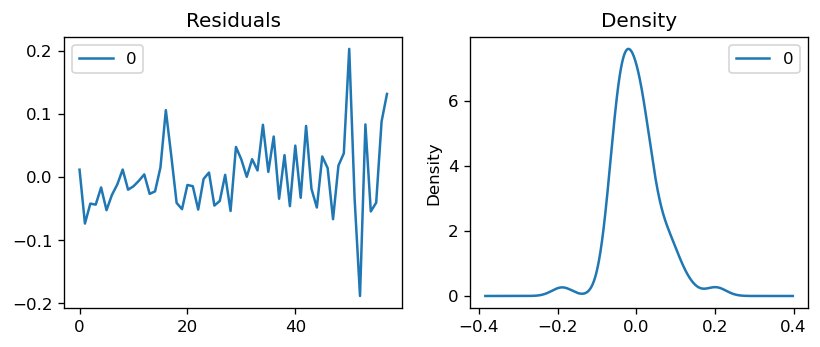

In [46]:
residuals = pd.DataFrame(model_fit.resid)
plt.rcParams.update({"figure.figsize": (8, 3), 'figure.dpi':120})
fig, ax = plt.subplots(1, 2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title="Density", ax=ax[1])
plt.show()

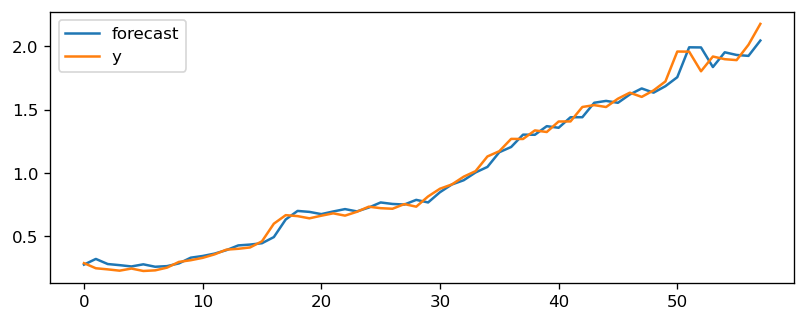

In [51]:
model_fit.plot_predict(dynamic=False)
plt.show()

[2.211815709942742, 2.245169866388244, 2.278524022833746, 2.311878179279248, 2.34523233572475, 2.378586492170252, 2.411940648615754, 2.445294805061256, 2.478648961506758, 2.51200311795226]


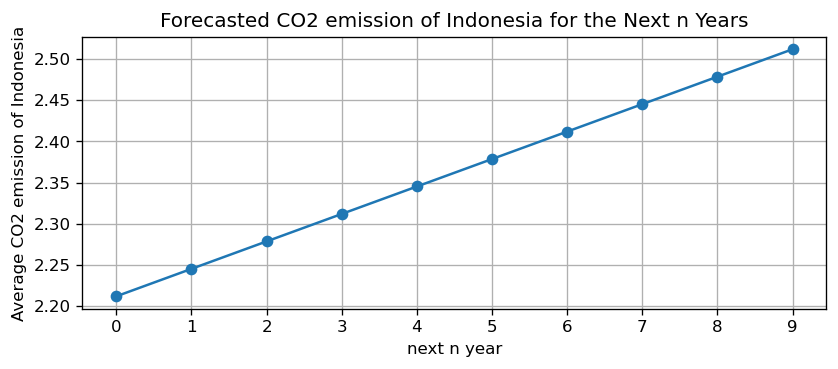

In [52]:
forecast = model_fit.forecast(steps=10)[0]
forecast_values = []
for value in forecast:
    forecast_values.append(value)

plt.plot(range(0, len(forecast_values)), forecast_values, marker="o")
plt.xticks(range(0, len(forecast_values)))
plt.xlabel("next n year")
plt.ylabel("Average CO2 emission of Indonesia")
plt.title("Forecasted CO2 emission of Indonesia for the Next n Years")
plt.grid()
print(forecast_values)